# 信用卡數字辨識

## 專案介紹
影像辨識在金融界應用廣泛，電腦可以協助人們完成重覆性高的工作，減少人力負擔，提升工作效率。本專案此為發想應用 OpenCV 技術識別信用卡號碼，因為信用卡數字有特定的模式，因此，不需要使用神經網路就可以達到辨識的目的，專案步驟如下：

0. [導入模塊](#title1)
1. [定義基礎函數](#title2)
2. [模板預處理](#title3)
3. [建立數字與圖像的對應](#title4)
4. [樹入圖像預處理](#title5)
5. [選取合適的 Bounding Boxes](#title6)
6. [判斷 Bounding Boxes 內的數字](#title7)

## <span id="title1">Step0:導入模塊

In [1]:
from platform import python_version
import cv2
from imutils import contours
import numpy as np
import matplotlib.pyplot as plt

print('Python Version: ', python_version())
print('OpenCV Version: ', cv2.__version__ )
print('NumPy Version: ', np.__version__ )

Python Version:  3.7.8
OpenCV Version:  4.5.1
NumPy Version:  1.19.5


## <span id="title2">Step1:定義基本函數
+ sort_contours(cnts, method): 根據排序方法 method 對輪廓 cnts 進行排序，返回排序過後的輪廓與輪廓對應的 bounding boxes
+ cv_show(name, img): 輸出 img 圖像，圖像名稱為 name

In [2]:
def sort_contours(cnts, method="left-to-right"):
    """
    將輪廓從左到右排序
    """
    reverse = False
    i = 0

    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
        
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes), key=lambda b: b[1][i], reverse=reverse))  # 從左到右排序
    
    return cnts, boundingBoxes

def cv_show(name,img):
    """
    顯示圖片
    """
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(name)
    plt.xticks([])
    plt.yticks([])
    plt.show()

## <span id="title3">Step2:模板預處理
本步驟是為了找出模板輪廓，而對數字模板進行預處理，操作步驟如下：
+ 讀取圖像
+ 轉為灰度圖像
+ 轉為二值圖像
+ 找出輪廓

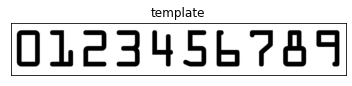

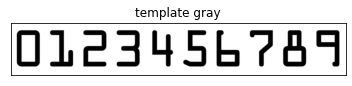

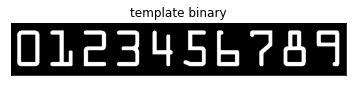

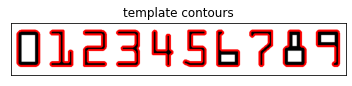

number of contours:10


In [3]:
# 讀取模板圖像
template = cv2.imread(r".\images\template.png")
cv_show('template', template)

# 轉為灰度圖像
template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
cv_show('template gray', template_gray)

# 轉為二值圖像
template_binary = cv2.threshold(template_gray, 10, 255, cv2.THRESH_BINARY_INV)[1]
cv_show('template binary', template_binary)

# 找出輪廓
template_cnts, hierarchy = cv2.findContours(template_binary.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv_show('template contours', cv2.drawContours(template.copy(), template_cnts, -1, (0, 0, 255), 3))

print("number of contours:{}".format(len(template_cnts)))

## <span id="title4">Step3:建立數字與圖像的對應
本步驟會剪取模板中每個數字對應的方塊圖像，使用 digits 字典儲存所有方塊圖像，這樣一來，我們可以使用這些圖像與信用卡上的每個數字進行比對。

分割模板後的方塊:


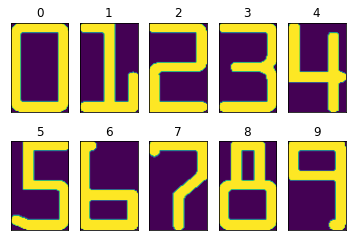

In [4]:
template_cnts = sort_contours(template_cnts, method="left-to-right")[0]  # 對輪廓進行排序 --> 從左到右

# 建立一對一對應的字典
digits = {}
for (i, c) in enumerate(template_cnts):
    """
    產生 digits 字典
    key: digit 
    value: digit reference
    """
    x, y, w, h = cv2.boundingRect(c)
    roi = template_binary[y:y + h, x:x + w]
    roi = cv2.resize(roi, (57, 88))
    digits[i] = roi

# 顯示圖片
print("分割模板後的方塊:")
for key, value in digits.items():
    plt.subplot(2, 5, key+1)
    plt.title(str(key))
    plt.imshow(value)
    plt.xticks([])
    plt.yticks([])

plt.show()

## <span id="title5">Step4:輸入圖像預處理
本步驟會使用 OpenCV 的各種操作對輸入圖像預處理，可以清楚觀察到預處理後的圖像(**如下圖**)大致標示出信用卡上每個區塊的輪廓。

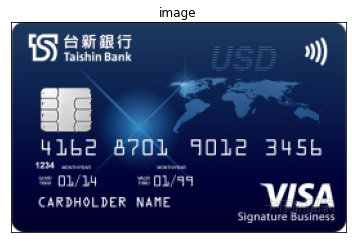

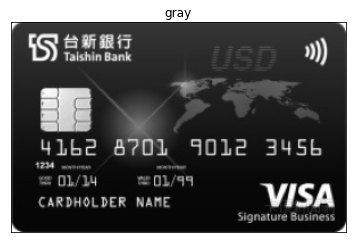

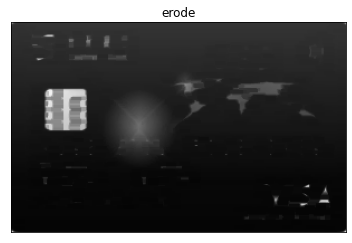

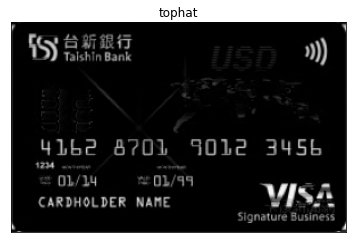

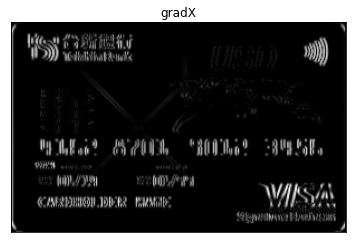

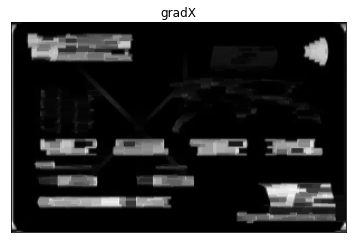

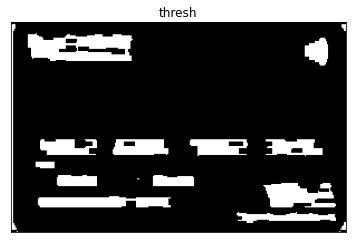

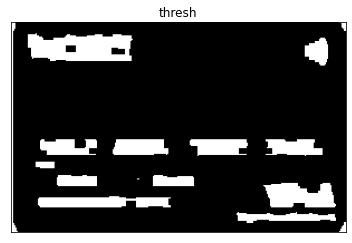

In [5]:
# 定義 kerenl
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

# 讀取圖像
image = cv2.imread(r".\images\taishin.png")
cv_show('image',image)

# resize
h, w = image.shape[:2]
r = 300 / float(w)
dim = (300, int(h * r))
image = cv2.resize(image, dim)

# 轉為灰度圖
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv_show('gray',gray)

#  腐蝕操作
cv_show('erode', cv2.erode(gray, rectKernel))

# tophat 操作
tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, rectKernel) 
cv_show('tophat',tophat)

# 梯度運算
gradX = cv2.Sobel(tophat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal))).astype("uint8")
cv_show('gradX',gradX)

# 閉操作: 先膨脹, 再腐蝕
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel) 
cv_show('gradX',gradX)

#二值化操作，THRESH_OTSU 會自動找閾值
thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1] 
cv_show('thresh',thresh)

#閉操作
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
cv_show('thresh', thresh)

## <span id="title6">Step5:選取合適的 Bounding Boxes
本步驟會使用一些條件式與基本函數 sort_contours 篩選出信用卡帳號對應的輪廓，並找出對應的 Bounding Boxes。

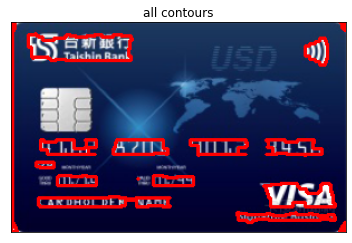

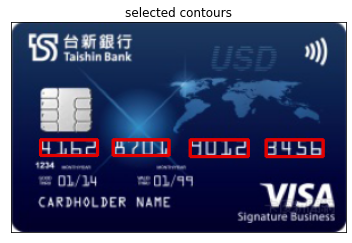

In [6]:
# 信用卡輪廓
image_cnts, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv_show('all contours', cv2.drawContours(image.copy(), image_cnts, -1, (0, 0, 255), 2))
locs = []

# 找出需要的輪廓
for (i, c) in enumerate(image_cnts):
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)
    if ar > 2.5 and ar < 4.0:
        if (w > 40 and w < 55) and (h > 10 and h < 20):
            locs.append((x, y, w, h))

# 對輪廓從左到右排序
locs = sorted(locs, key=lambda x:x[0])

image_copy = image
for loc in locs:
    cv2.rectangle(image_copy, (loc[0], loc[1]), (loc[0] + loc[2], loc[1] + loc[3]), (0,0,225), thickness=2)
cv_show('selected contours', image_copy)

## <span id="title7">Step6:判斷 Bounding Boxes 內的數字
上一步驟我們找出數字區塊的 Bounding Boxes，接下來我們會對每個 Bouning Box 再進行方割，使得分割後的方塊為信用卡帳號的每個數字，再使用 OpenCV 的 matchTemplate 函數與 digits 字典判斷每個該方塊對應的數字。

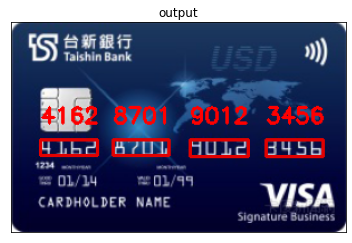

credit card number:4162 8701 9012 3456


In [7]:
# 求出求出每個 rectangle 對應的數字 
output = []

for i, (gX, gY, gW, gH) in enumerate(locs):
    group_output = []
    
    # 剪取每一組的圖像
    group = gray[gY - 5:gY + gH + 5, gX - 5:gX + gW + 5]
    
    # 二值化操作
    group = cv2.threshold(group, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
    # 膨脹操作
    group = cv2.dilate(group, (4,4))
    
    # 計算該組圖像的輪廓
    digitCnts, hierarchy = cv2.findContours(group.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    digitCnts = contours.sort_contours(digitCnts, method = "left-to-right")[0]

    # 計算每個輪廓對應的數字
    for c in digitCnts:
        (x, y, w, h) = cv2.boundingRect(c)
        roi = group[y:y + h, x:x + w]
        roi = cv2.resize(roi, (57, 88))
        # 計算得分
        scores = []
        for (digit, digitROI) in digits.items():
            # 模板匹配
            result = cv2.matchTemplate(roi, digitROI, cv2.TM_CCOEFF)
            score = cv2.minMaxLoc(result)[1]
            scores.append(score)
        group_output.append(str(np.argmax(scores)))
    
    cv2.putText(image, "".join(group_output), (gX, gY - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 0, 255), 2)    
    output.append(group_output)

cv_show('output', image)
print("credit card number:{}".format(" ".join(["".join(alist) for alist in output])))